<a href="https://colab.research.google.com/github/daost2001/X-ray-image-classification/blob/main/ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
#all of the imports initialized, some are also used later on
import numpy as np
import pandas as pd
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import glob
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from keras.utils.vis_utils import plot_model
from PIL import Image

In [50]:
#installs kaggle, accepts kaggle.json from user, then downloads files from kaggle
! pip install -q kaggle
from google.colab import files
files.upload() #get api token from kaggle and upload kaggle.json file

!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


!kaggle datasets download paultimothymooney/chest-xray-pneumonia

! unzip chest-xray-pneumonia.zip

Saving kaggle.json to kaggle.json
chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  chest-xray-pneumonia.zip
replace chest_xray/__MACOSX/._chest_xray? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [51]:
#defining directories
train_directory= "chest_xray/chest_xray/train/"
val_directory="chest_xray/chest_xray/val/"
test_directory="chest_xray/chest_xray/test/"

In [67]:
#shows class names
data_dir = train_directory
class_names=os.listdir(train_directory)
if class_names[1] == 'NORMAL':
  class_names.pop(0)
else:
  class_names.pop()
print(class_names)

['NORMAL', 'PNEUMONIA']


In [53]:
#defines the image returning function to find random images 
def view_random_image(target_directory, target_class):
    target_folder = target_directory + target_class
    random_image = random.sample(os.listdir(target_folder), 1)
    img = mpimg.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off");
    return img

In [54]:
#Shows the number of images in each set of images in the folder
input_path="chest_xray/chest_xray/"
for _set in ['train', 'val', 'test']:
    n_normal = len(os.listdir(input_path + _set + '/NORMAL'))
    n_infect = len(os.listdir(input_path + _set + '/PNEUMONIA'))
    print('Set: {}, Normal images: {}, pneumonia images: {}'.format(_set, n_normal, n_infect))

Set: train, Normal images: 1342, pneumonia images: 3876
Set: val, Normal images: 9, pneumonia images: 9
Set: test, Normal images: 234, pneumonia images: 390


In [55]:
# Re-sizing the images
IMAGE_SIZE = (224, 224,3)
# Default batch size
BATCH_SIZE = 32

In [56]:
#generates images using image generator with brightness, random rotation
#rescales and zooms
Image_gen = ImageDataGenerator(
        rescale = 1/255,
        shear_range=10,
        zoom_range=0.3,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=[0.5,2.0],
        width_shift_range = 0.2,
        rotation_range=20,
        fill_mode = 'nearest'
)
val_Datagen = ImageDataGenerator(
        rescale = 1/255
)

In [57]:
#initializes counts of numbers, adds onto directories
train_count = 0
infect_count = 0
norm_count = 0
train_count_in = train_directory + 'PNEUMONIA/'
train_count_norm = train_directory + 'NORMAL/'
val_count_in = val_directory + 'PNEUMONIA/'
val_count_norm = val_directory + 'NORMAL/'
test_count_in = test_directory + 'PNEUMONIA/'
test_count_norm = test_directory + 'NORMAL/'

#counts training, infected, and normal images
for path in os.listdir(val_count_in):
    if os.path.isfile(os.path.join(val_count_in, path)):
        infect_count += 1
for path in os.listdir(train_count_in):
    if os.path.isfile(os.path.join(train_count_in, path)):
        infect_count += 1
        train_count += 1
for path in os.listdir(test_count_in):
    if os.path.isfile(os.path.join(test_count_in, path)):
        infect_count += 1
for path in os.listdir(train_count_norm):
    if os.path.isfile(os.path.join(train_count_norm, path)):
        norm_count += 1      
        train_count += 1
for path in os.listdir(val_count_norm):
    if os.path.isfile(os.path.join(val_count_norm, path)):
        norm_count += 1
for path in os.listdir(test_count_norm):
    if os.path.isfile(os.path.join(test_count_norm, path)):
        norm_count += 1            


#calculates class weights
weight_for_0 = (1 / norm_count)*(train_count)/2.0 
weight_for_1 = (1 / infect_count)*(train_count)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}
#outputs class weights for each class
print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.65
Weight for class 1: 0.61


In [58]:
#defines each set of images using an image generator
train = Image_gen.flow_from_directory(train_directory,
                                      #batch size of 32
                                       batch_size=32,
                                       class_mode='binary',
                                       target_size=(224,224))
                                       

validation = Image_gen.flow_from_directory(val_directory,
                                           #batch size of 16
                                              batch_size=16,
                                              class_mode='binary',
                                             target_size=(224,224))
                                            

test = val_Datagen.flow_from_directory(test_directory,
                                       #batch size of 16
                                       batch_size=16,
                                       class_mode='binary',
                                       target_size=(224,224))
                                      

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [59]:
#defines img and label
img, label = next(train)

In [60]:
#defines ealry stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=10)

In [61]:
#defines callbacks
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                          patience=8)

In [62]:
#function for creating model using ResNet50V2
def create_model():
  #download from tensorflow keras
    resnet_model = tf.keras.applications.ResNet50V2(
        weights='imagenet',
        include_top = False,
        #uses 224x224x3 Shape
        input_shape = (224,224,3)
    )
    #defines trainable layers
    for layer in resnet_model.layers:
        layer.trainable=False

    x = resnet_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(128,activation='relu')(x)
    # output layer
    predictions = tf.keras.layers.Dense(1,activation='sigmoid')(x)

    res_model = tf.keras.Model(inputs=resnet_model.input, outputs=predictions)

    # Compiling the model
    res_model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
    return res_model

In [63]:
#creates model from ResNet50V2 model
res_model = create_model()

In [64]:
#Displays the layers and their shapes and function
res_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

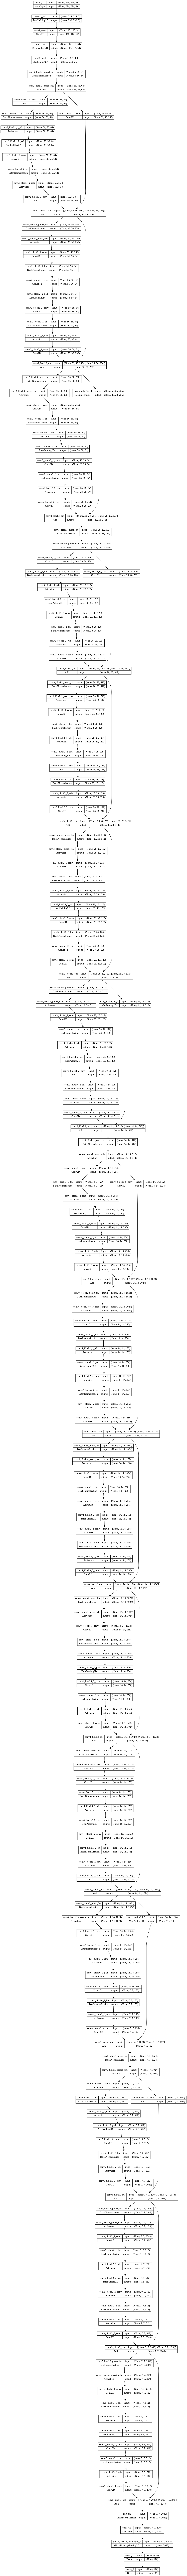

In [65]:
#Takes the model from res_model and displays the model for ResNet
plot_model(res_model, to_file='cnn_model.png', show_shapes=True, show_layer_names=True)
display(Image.open('cnn_model.png'))

In [68]:
#trains the model using 20 epochs, 50 steps each, a batch size of 32
#class weights and early stopping
history = res_model.fit(train,epochs=20, 
                    validation_data=validation,
                     steps_per_epoch=50,
                    callbacks=[early_stopping,lr],
                    batch_size=32,
                    class_weight = class_weight,)

Epoch 1/20
50/50 [==============================] - 263s 5s/step - loss: 0.2738 - accuracy: 0.8675 - val_loss: 1.2810 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 2/20
50/50 [==============================] - 259s 5s/step - loss: 0.2344 - accuracy: 0.8869 - val_loss: 1.1996 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 3/20
50/50 [==============================] - 262s 5s/step - loss: 0.2253 - accuracy: 0.8988 - val_loss: 0.6000 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 4/20
50/50 [==============================] - 258s 5s/step - loss: 0.2234 - accuracy: 0.8988 - val_loss: 0.4699 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 5/20
50/50 [==============================] - 264s 5s/step - loss: 0.2136 - accuracy: 0.8938 - val_loss: 0.5226 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 6/20
50/50 [==============================] - 270s 5s/step - loss: 0.1999 - accuracy: 0.9025 - val_loss: 1.0346 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 7/20
50/50 [==============================] - 258s 5s/step - loss: 0.2

Text(0, 0.5, 'Loss')

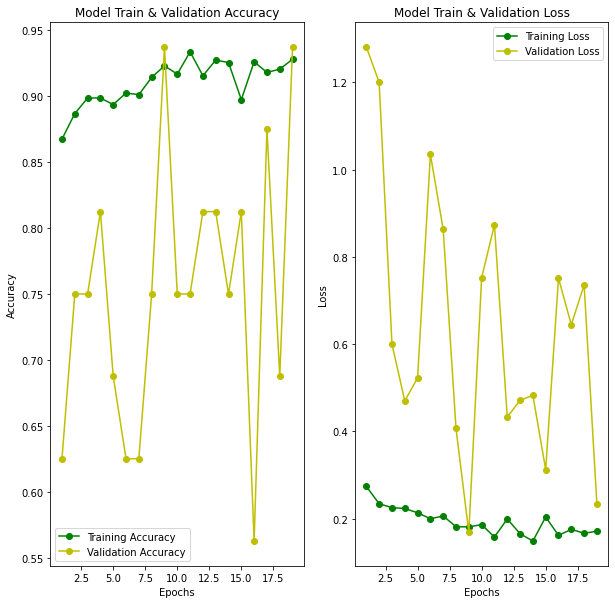

In [69]:
#Plot the training artifacts
fig , ax = plt.subplots(1, 2)
fig.set_size_inches(10, 10)

#takes the trained epochs from training accuracy and loss
train_acc = history.history['accuracy']
train_loss = history.history['loss']

#takes the trained epochs from validation accuracy and loss
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)
#plots the model train and validation accuracy
ax[0].plot(epochs, train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'yo-' , label = 'Validation Accuracy')
ax[0].set_title('Model Train & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel('Epochs') 
ax[0].set_ylabel('Accuracy')

#plots the model train and validation loss
ax[1].plot(epochs, train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs, val_loss , 'yo-' , label = 'Validation Loss')
ax[1].set_title('Model Train & Validation Loss')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')

7/7 [==============================] - 3s 401ms/step


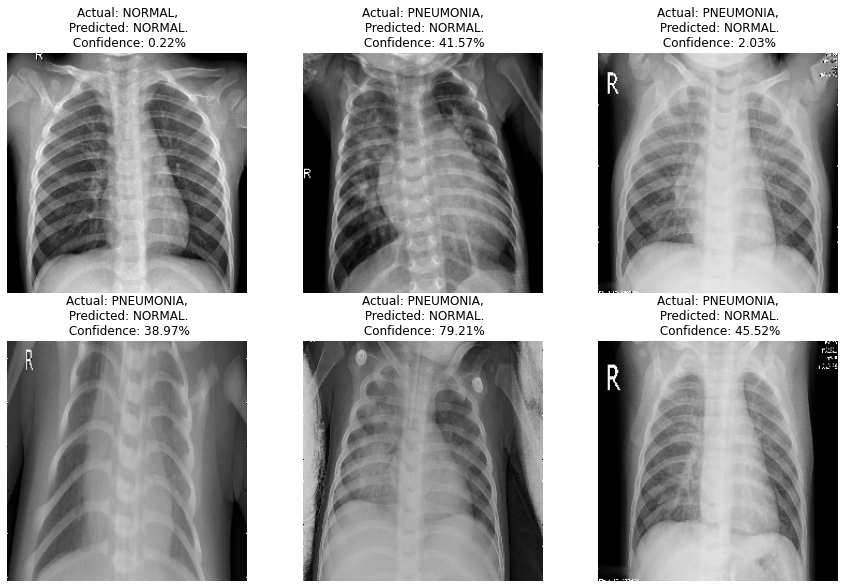

In [70]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i])
    #uses an if elif statement due to issues in displaying predictions
    if i<3:
      #calcuates predictions and expands dimensions
      img_array = tf.expand_dims(img_array,i)
      predictions = model.predict(img_array)
      predicted_class = class_names[np.argmax(predictions[0])]
      #rounds up percentages
      confidence = round(100 * (np.max(predictions[0])), 2)
      #returns confidence and predicted class
      return predicted_class, confidence
    elif i >= 3:
      #calcuates predictions and expands dimensions
      img_array = tf.expand_dims(img_array,1)
      predictions = model.predict(img_array)
      predicted_class = class_names[np.argmax(predictions[0])]
      #rounds up percentages
      confidence = round(100 * (np.max(predictions[0])), 2)
      #returns confidence and predicted class
      return predicted_class, confidence

#plots figures 15x15
plt.figure(figsize=(15, 15))

for images, labels in test:
  #plots 6 predictions
    for i in range(6):
        ax = plt.subplot(3, 3, i + 1)
        #shows the images
        plt.imshow(images[i])


        actual_class = class_names[int(labels[i])] 
        predicted_class, confidence = predict(res_model, images[i])
        #plots actual vs predicted
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")
        #breaks after displaying each
    break

In [71]:
#imports confusion matrix
import glob
from pathlib import Path
import cv2
from keras.utils import to_categorical
from mlxtend.plotting import plot_confusion_matrix
#creates directories to each test case
normal_cases_dir = Path("chest_xray/chest_xray/test/NORMAL")
pneumonia_cases_dir = Path("chest_xray/chest_xray/test/PNEUMONIA")
#creates test data and labels as well as cases
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')
test_data = []
test_labels = []
#creates a for loop that appends to the test labels in the normal cases
for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (128,128))
    if img.shape[2] == 1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes=2)
    test_data.append(img)
    test_labels.append(label)
#creates a for loop that appends to the test labels in the pneumonia cases
for img in pneumonia_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (128,128))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=2)
    test_data.append(img)
    test_labels.append(label)


#makes test data and test labels into an array
test_data = np.array(test_data)
test_labels = np.array(test_labels)
#prints out the test data and labels shapes
print("Total number of test examples: ", test_data.shape)
print("Total number of labels:", test_labels.shape)

Total number of test examples:  (624, 128, 128, 3)
Total number of labels: (624, 2)


In [72]:
# Evaluating the model on train and test
score = res_model.evaluate(train)
#calculates training loss and accuracy
print("Train Loss: ", score[0])
print("Train Accuracy: ", score[1])
#calculates Test loss and accuracy
score = res_model.evaluate(test)
print("\nTest loss: ", score[0])
print("Test Accuracy: ", score[1])
#calculates validation loss and accuracy
score = res_model.evaluate(validation)
print("\nValidation loss: ", score[0])
print("Validation Accuracy: ", score[1])

163/163 [==============================] - 845s 5s/step - loss: 0.1950 - accuracy: 0.9197
Train Loss:  0.19499816000461578
Train Accuracy:  0.9196702241897583
39/39 [==============================] - 91s 2s/step - loss: 0.2769 - accuracy: 0.8846

Test loss:  0.2769272029399872
Test Accuracy:  0.8846153616905212
1/1 [==============================] - 3s 3s/step - loss: 0.7306 - accuracy: 0.7500

Validation loss:  0.7306480407714844
Validation Accuracy:  0.75


In [73]:
#predicts using .predict to find the confusion matrix
preds = res_model.predict(test_data, batch_size=16,verbose=1)
preds=np.around(preds)
orig_test_labels=test_labels

39/39 [==============================] - 29s 744ms/step


<Figure size 432x288 with 0 Axes>

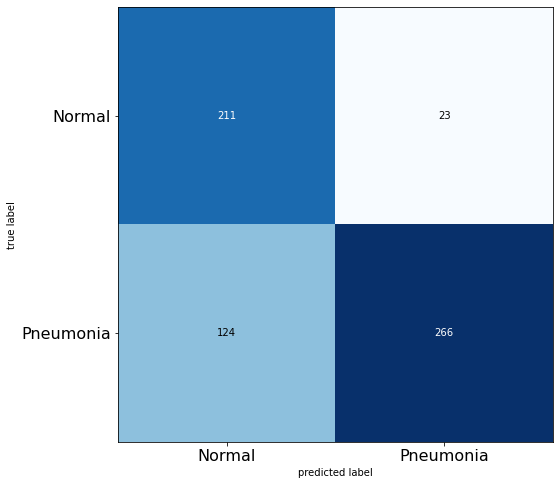

In [74]:
#stores orignal test labels
orig_test_labels = np.argmax(test_labels, axis=-1)
# imports confusion matrix
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

#plots confusion matrix using the original test labels and predictions from previous box
cm  = confusion_matrix(orig_test_labels, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

In [75]:
#Displays classification report, including accuracy, precision, F1-score, and Recall
from sklearn.metrics import classification_report
print(classification_report(orig_test_labels, preds, target_names = class_names))

              precision    recall  f1-score   support

      NORMAL       0.63      0.90      0.74       234
   PNEUMONIA       0.92      0.68      0.78       390

    accuracy                           0.76       624
   macro avg       0.78      0.79      0.76       624
weighted avg       0.81      0.76      0.77       624

